# Bidirectional LSTM (Left Wrist)

##### https://www.kaggle.com/malekzadeh/human-activity-recognition-with-mobile-sensing

##### https://github.com/akhuperkar/HAR-Smartphone-Accelerometer/blob/master/HAR%20Using%20Machine%20Learning%20.ipynb

#### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats
import math

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import seaborn as sns
from tensorflow import keras

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

from collections import defaultdict, Counter

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('gyr_data_left_wrist.csv')
df = df.drop([0])

In [5]:
print(df)

     PacketCounter  SampleTimeFine       Gyr_X       Gyr_Y      Gyr_Z  \
1                1        79897288  -58.390606   93.736000  25.881578   
2                2        79913955  -74.599442   98.117401  33.774197   
3                3        79930622  -96.426018  101.997231  44.852615   
4                4        79947289 -124.858711  103.756897  57.781734   
5                5        79963956 -151.972092  104.858955  69.761574   
..             ...             ...         ...         ...        ...   
400            400        86547421  -23.316536   -4.813910  -0.109783   
401            401        86564088  -20.502579   -4.401914  -3.276708   
402            402        86580755  -13.027262   -3.750080  -3.135976   
403            403        86597422  -16.389172  -10.882780  -4.867873   
404            404        86614089  -27.302483  -16.614273  -9.451398   

    Unnamed: 11  
1                
2                
3                
4                
5                
..          ...

In [6]:
df2 = pd.read_csv('gyr_data_left_wrist_label.csv')
df2 = df2.drop([0])
print(df2)

     PacketCounter  SampleTimeFine  Label
1                1        79897288      1
2                2        79913955      1
3                3        79930622      1
4                4        79947289      1
5                5        79963956      1
..             ...             ...    ...
400            400        86547421      3
401            401        86564088      3
402            402        86580755      3
403            403        86597422      3
404            404        86614089      3

[404 rows x 3 columns]


In [7]:
df_train = df
label_train = df2
print("Shape of original data:", df_train.shape)
print("Shape of labels data:", label_train.shape)

Shape of original data: (404, 6)
Shape of labels data: (404, 3)


In [8]:
print(df_train.head())

   PacketCounter  SampleTimeFine       Gyr_X       Gyr_Y      Gyr_Z  \
1              1        79897288  -58.390606   93.736000  25.881578   
2              2        79913955  -74.599442   98.117401  33.774197   
3              3        79930622  -96.426018  101.997231  44.852615   
4              4        79947289 -124.858711  103.756897  57.781734   
5              5        79963956 -151.972092  104.858955  69.761574   

  Unnamed: 11  
1              
2              
3              
4              
5              


In [10]:
def magnitude(activity):
    x2 = activity['Gyr_X'] * activity['Gyr_X']
    y2 = activity['Gyr_Y'] * activity['Gyr_Y']
    z2 = activity['Gyr_Z'] * activity['Gyr_Z']
    m2 = x2 + y2 + z2
    m = m2.apply(lambda x: math.sqrt(x))
    return m

df_train['m'] = magnitude(df_train)
df_train.head()

,PacketCounter,SampleTimeFine,Gyr_X,Gyr_Y,Gyr_Z,Unnamed: 11,m
1,1,79897288,-58.390606,93.736000,25.881578,,113.427319
2,2,79913955,-74.599442,98.117401,33.774197,,127.799833
3,3,79930622,-96.426018,101.997231,44.852615,,147.353890
4,4,79947289,-124.858711,103.756897,57.781734,,172.319239
5,5,79963956,-151.972092,104.858955,69.761574,,197.376783


In [11]:
print(label_train.head())

   PacketCounter  SampleTimeFine  Label
1              1        79897288      1
2              2        79913955      1
3              3        79930622      1
4              4        79947289      1
5              5        79963956      1


In [12]:
pd.DataFrame.from_dict(Counter(label_train['Label']), orient="Index", columns=['label']).reset_index()

,index,label
0,1,81
1,2,169
2,3,154


#### Plot Acceleration Data

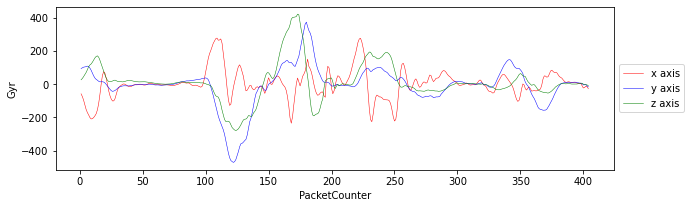

In [13]:
plt.figure(figsize=(10,3))
plt.plot(df_train['PacketCounter'], df_train['Gyr_X'], linewidth=0.5, color='r', label='x axis')
plt.plot(df_train['PacketCounter'], df_train['Gyr_Y'], linewidth=0.5, color='b', label='y axis')
plt.plot(df_train['PacketCounter'], df_train['Gyr_Z'], linewidth=0.5, color='g', label='z axis')
plt.xlabel('PacketCounter')
plt.ylabel('Gyr')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

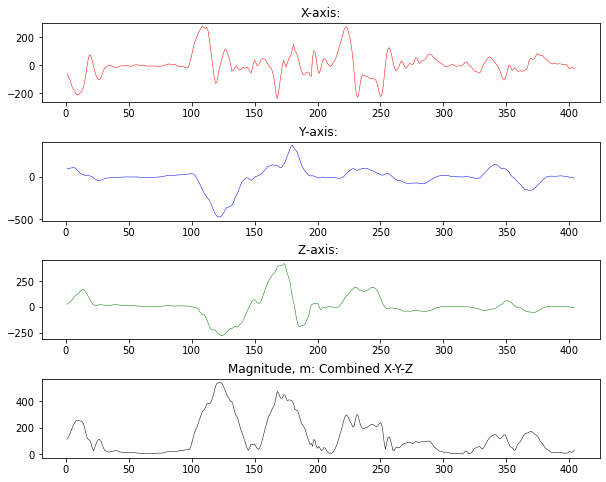

In [14]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

ax[0].set_title('X-axis:')
ax[0].plot(df_train['PacketCounter'], df_train['Gyr_X'], linewidth=0.5, color='r')

ax[1].set_title('Y-axis: ')
ax[1].plot(df_train['PacketCounter'], df_train['Gyr_Y'], linewidth=0.5, color='b')

ax[2].set_title('Z-axis: ')
ax[2].plot(df_train['PacketCounter'], df_train['Gyr_Z'], linewidth=0.5, color='g')

ax[3].set_title('Magnitude, m: Combined X-Y-Z')
ax[3].plot(df_train['PacketCounter'], df_train['m'], linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

In [15]:
# Separating data for each activity
train_df = pd.concat([df_train, label_train['Label']], axis=1).dropna()
columns = ['PacketCounter', 'Gyr_X', 'Gyr_Y', 'Gyr_Z', 'm', 'Label']

idle = train_df[columns][train_df.Label == 1]
waack = train_df[columns][train_df.Label == 2]
wrist_on_elbow = train_df[columns][train_df.Label == 3]

In [16]:
wrist_on_elbow.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
251,251,-213.597000,20.827213,56.392113,221.895294,3
252,252,-161.469696,20.511398,29.164972,165.359535,3
253,253,-76.959274,26.592499,6.938375,81.719226,3
254,254,12.915119,35.627033,-8.149487,38.762094,3
255,255,82.524986,40.188549,-17.805826,93.501552,3


In [17]:
waack.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
82,82,10.007911,15.060268,13.188450,22.380911,2
83,83,8.711575,16.390980,12.718203,22.501298,2
84,84,6.873602,17.893446,10.644144,21.925319,2
85,85,5.828820,19.545366,9.067372,22.320702,2
86,86,7.290476,19.196587,8.380875,22.178797,2


In [18]:
idle.head()

,PacketCounter,Gyr_X,Gyr_Y,Gyr_Z,m,Label
1,1,-58.390606,93.736000,25.881578,113.427319,1
2,2,-74.599442,98.117401,33.774197,127.799833,1
3,3,-96.426018,101.997231,44.852615,147.353890,1
4,4,-124.858711,103.756897,57.781734,172.319239,1
5,5,-151.972092,104.858955,69.761574,197.376783,1


#### Plot Activity Data

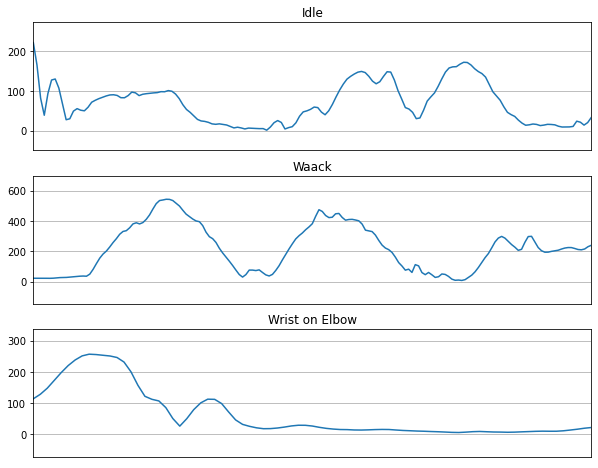

In [38]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)
    
def plot_activity(activities, titles):
    fig, axs = plt.subplots(nrows=len(activities), figsize=(10, 8))
    for i in range(0, len(activities)):
        plot_axis(axs[i], activities[i]['PacketCounter'], activities[i]['m'], titles[i])
    plt.subplots_adjust(hspace=0.2)
    plt.show()

plot_activity([wrist_on_elbow, waack, idle],
              ['Idle', 'Waack', 'Wrist on Elbow'])

#### Split training data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label_train, test_size = 0.2, random_state = 0)

In [21]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (323, 8)
y_train shape: (323, 3)


In [22]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_test shape: (81, 8)
y_test shape: (81, 3)


In [23]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = label_train['Label'].iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 300 #400 #200 #300
STEP = 150  #100 #60 #80 #40 #150

X_train, y_train = create_dataset(
    df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']], 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df[['Gyr_X', 'Gyr_Y', 'Gyr_Z']], 
    TIME_STEPS, 
    STEP
)

In [24]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 1)


In [25]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [26]:
print(X_train.shape, y_train.shape)

(254, 150, 3) (254, 3)


#### Train the model

In [27]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[0], X_train.shape[1]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [28]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64, #64 #128 #32
    validation_split=0.1,
    shuffle=True
)

Train on 228 samples, validate on 26 samples
Epoch 1/20
228/228 [==============================] - 4s 17ms/sample - loss: 1.0133 - acc: 0.4956 - val_loss: 1.9871 - val_acc: 0.0769
Epoch 2/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.4229 - acc: 0.9123 - val_loss: 2.7103 - val_acc: 0.0385
Epoch 3/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.2123 - acc: 0.9474 - val_loss: 3.3640 - val_acc: 0.0385
Epoch 4/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.1388 - acc: 0.9649 - val_loss: 3.8517 - val_acc: 0.0385
Epoch 5/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0936 - acc: 0.9693 - val_loss: 4.2102 - val_acc: 0.0385
Epoch 6/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0569 - acc: 0.9868 - val_loss: 4.3772 - val_acc: 0.0385
Epoch 7/20
228/228 [==============================] - 1s 4ms/sample - loss: 0.0505 - acc: 0.9825 - val_loss: 4.5014 - val_acc: 0.0385
Epoch 8/20
228/2

#### Evaluation

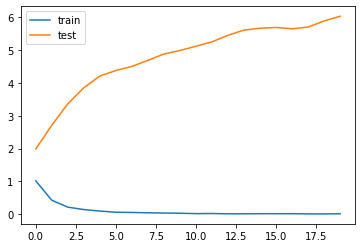

In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

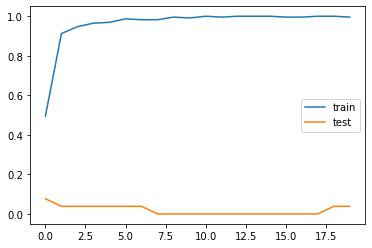

In [30]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend();

In [31]:
model.evaluate(X_test, y_test)

254/254 [==============================] - 0s 758us/sample - loss: 0.6204 - acc: 0.9016


[0.6204409362165272, 0.9015748]

In [32]:
model.evaluate(X_train, y_train)

254/254 [==============================] - 0s 758us/sample - loss: 0.6204 - acc: 0.9016


[0.6204409362165272, 0.9015748]

#### Confusion Matrix

In [35]:
y_pred = model.predict(X_test)

In [36]:
column_names = 'Idle', 'Waack', 'Wrist_on_Elbow'

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(column_names)
  ax.set_yticklabels(column_names)
  b, t = plt.ylim() # discover the values for bottom and top
  #b += 0.5 # Add 0.5 to the bottom
  #t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

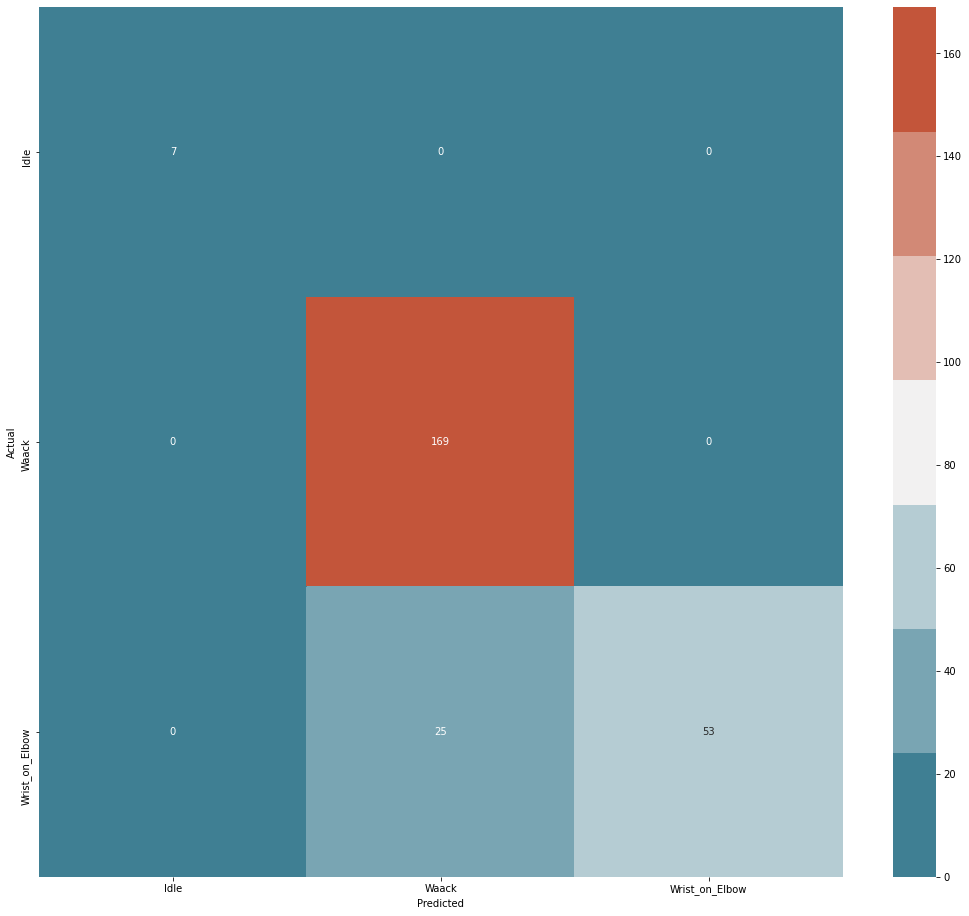

In [37]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)